# Setting up workspace

In [55]:
import pandas as pd
import glob
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy.spatial.distance import cdist
import geopy.distance
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
import datetime



### Datasets

We'll be using 6 different datasets, one for each 6 last months, of data about all the `Bicing stations ACIVITY` in Barcelona from March 2019 to March 2020.
We'll also be using one dataset which contains additional information about the `Bicing Station INFORMATION`.

In [2]:
# We'll merge all datasets we have in the folder, since all of them have the same structure:

path = 'Data'
files = glob.glob(path + "/activity/*.csv")

csvs = []

for csv in files:
    df = pd.read_csv(csv)
    csvs.append(df)

activity = pd.concat(csvs, axis=0, sort=False)

In [4]:
activity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20135921 entries, 0 to 3398707
Data columns (total 13 columns):
station_id                              int64
num_bikes_available                     int64
num_bikes_available_types.mechanical    int64
num_bikes_available_types.ebike         int64
num_docks_available                     int64
is_installed                            int64
is_renting                              int64
is_returning                            int64
last_reported                           float64
is_charging_station                     bool
status                                  object
last_updated                            int64
ttl                                     int64
dtypes: bool(1), float64(1), int64(10), object(1)
memory usage: 2.0+ GB


In [5]:
activity.head()

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl
0,1,27,25,2,17,1,1,1,1.580512e+09,True,IN_SERVICE,1580511611,21
1,2,0,0,0,26,1,1,1,1.580511e+09,True,IN_SERVICE,1580511611,21
2,3,25,25,0,1,1,1,1,1.580511e+09,True,IN_SERVICE,1580511611,21
3,4,8,8,0,10,1,1,1,1.580511e+09,True,IN_SERVICE,1580511611,21
4,5,34,33,1,4,1,1,1,1.580511e+09,True,IN_SERVICE,1580511611,21


For the `Bicing Station INFORMATION` dataframe, we'll import it from a JSON file:

In [6]:
info = pd.read_json('Data/station_information.json')

In [7]:
info.head()

,last_updated,ttl,data
stations,1585388305,25,"[{'station_id': 1, 'name': 'GRAN VIA CORTS CAT..."


The info that we need comes in form of a dictionary in the `'data'` column:

In [8]:
data = info.data.values[0]

info = pd.DataFrame.from_dict(data)

info.set_index('station_id')

,name,physical_configuration,lat,lon,altitude,address,post_code,capacity,nearby_distance,cross_street
station_id,,,,,,,,,,
1,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.397952,2.180042,21.0,"GRAN VIA CORTS CATALANES, 760",08908,46,1000.0,NaN
2,"C/ ROGER DE FLOR, 126",ELECTRICBIKESTATION,41.395530,2.177060,21.0,"C/ ROGER DE FLOR, 126",08908,27,1000.0,NaN
3,"C/ NÀPOLS, 82",ELECTRICBIKESTATION,41.394055,2.181299,22.0,"C/ NÀPOLS, 82",08908,27,1000.0,NaN
4,"C/ RIBES, 13",ELECTRICBIKESTATION,41.393480,2.181555,21.0,"C/ RIBES, 13",08908,21,1000.0,NaN
5,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",ELECTRICBIKESTATION,41.391075,2.180223,16.0,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",08908,39,1000.0,NaN
...,...,...,...,...,...,...,...,...,...,...
495,C/ DIPUTACIÓ - TARRAGONA,ELECTRICBIKESTATION,41.376708,2.148395,45.0,C/ DIPUTACIÓ - TARRAGONA,08908,24,1000.0,NaN
496,"C/ PROVENÇA, 445",ELECTRICBIKESTATION,41.404839,2.174820,21.0,"C/ PROVENÇA, 445",1,18,1000.0,NaN
507,"C/ SARDENYA, 494",ELECTRICBIKESTATION,41.410764,2.164096,0.0,"C/ SARDENYA, 494",08024,24,1000.0,NaN


In [9]:
info.head()

,station_id,name,physical_configuration,lat,lon,altitude,address,post_code,capacity,nearby_distance,cross_street
0,1,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.397952,2.180042,21.0,"GRAN VIA CORTS CATALANES, 760",08908,46,1000.0,NaN
1,2,"C/ ROGER DE FLOR, 126",ELECTRICBIKESTATION,41.395530,2.177060,21.0,"C/ ROGER DE FLOR, 126",08908,27,1000.0,NaN
2,3,"C/ NÀPOLS, 82",ELECTRICBIKESTATION,41.394055,2.181299,22.0,"C/ NÀPOLS, 82",08908,27,1000.0,NaN
3,4,"C/ RIBES, 13",ELECTRICBIKESTATION,41.393480,2.181555,21.0,"C/ RIBES, 13",08908,21,1000.0,NaN
4,5,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",ELECTRICBIKESTATION,41.391075,2.180223,16.0,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",08908,39,1000.0,NaN


In [10]:
info.columns

Index(['station_id', 'name', 'physical_configuration', 'lat', 'lon',
       'altitude', 'address', 'post_code', 'capacity', 'nearby_distance',
       'cross_street'],
      dtype='object')

We have a Dataset including the neighborhood name in every Bicing Station, so we'll join this `NOM` column to the `info` dataset later on, joining by `station_id`.

In [11]:
neighbourhoods = pd.read_csv('Data/bicing_por_barrios.csv', index_col='station_id')

In [12]:
neighbourhoods.head()

,Unnamed: 0,name,BARRI,NOM
station_id,,,,
1,0,"GRAN VIA CORTS CATALANES, 760",5,el Fort Pienc
2,1,"C/ ROGER DE FLOR, 126",5,el Fort Pienc
3,2,"C/ NÀPOLS, 82",5,el Fort Pienc
4,3,"C/ RIBES, 13",5,el Fort Pienc
17,14,"AV. MERIDIANA, 47 (ANNEXA A LA 16)",5,el Fort Pienc


We'll also use a dataset containing the index of the wealth of Barcelona citizens, and the total population, distributed by neighbourhoods. Data from 2017:

In [14]:
rfd = pd.read_csv('Data/rfd_index.csv')

In [15]:
rfd.head(5)

,Any,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Població,Índex RFD Barcelona = 100
0,2017,1,Ciutat Vella,1,el Raval,47986,71.2
1,2017,1,Ciutat Vella,2,el Barri Gòtic,16240,106.1
2,2017,1,Ciutat Vella,3,la Barceloneta,15101,79.6
3,2017,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",22923,99.4
4,2017,2,Eixample,5,el Fort Pienc,32048,106.5


# Analyzing and manipulating the datasets

We're analyzing all the information the columns of our datasets are giving us:

### Bicing Stations ACTIVITY:

- 1. `station_id`: Unique id of the Bicing station. This is a shared column with the one in the `info` dataset.
- 2. `num_bikes_available`: Number of bikes (both mechanical and electrical) available to withdraw
- 3. `num_bikes_available_types.mechanical`: Subset of `num_bikes_available` indicating mechanical ones
- 4. `num_bikes_available_types.ebike`: Subset of `num_bikes_available` indicating electrical ones
- 5. `num_docks_available`: Number of slots available to deposit any kind of bikes
- 6. `is_installed`: 0 or 1 (T/F) if the station is operative.
- 7. `is_renting`: 0 or 1 (T/F) if the station is operative.
- 8. `is_returning`: 0 or 1 (T/F) if the station is operative.
- 9. `last_reported`: Timestamp of the last movement in the station
- 10. `is_charging_station`: T/F if the station has charging capabilities.
- 11. `status`: Current status of the station
- 12. `last_updated`: Timestamp of the moment when the station sent the update to the server.
- 13. `ttl`: Some communication protocol metric, not useful for us

The following changes will be made:

- Renaming the columns:
 - `num_bikes_available` to `total_available`.
 - `num_bikes_available_types.mechanical` to `bikes` 
 - `num_bikes_available_types.ebike` to `ebikes`
 - `num_docks_available` to `empty_slots`
 - `last_reported`to `time`
 
- Dropping columns:
 - `is_charging_station`: All our entries contain a 1, so we assume all stations are the same type
 - `last_updated`: The time where the server got updated is not valuable for us
 - `ttl`: This is a metric which is not useful for us
 
- Adding column:
 - `capacity`: This will be the sum of `total_available` + `empty_slots`, which will tell the total capacity of the station
 - `p_bike`: This column computes the % chance (0-1) of getting a bike (`total_available` / `capacity`)
 - `p_slot`: This column computes the % chance (0-1) of be able to deposit a bike (1- `p_bike`)



In [16]:
activity.drop(columns=['is_charging_station', 'last_updated', 'ttl'], inplace= True)

In [17]:
activity['last_reported'] = pd.to_datetime(activity.last_reported, unit='s')

In [18]:
activity.columns = ['station_id', 'total_available', 'bikes', 'ebikes', 'empty_slots', 'is_installed', 'is_renting',
                    'is_returning', 'last_reported', 'status']

In [19]:
activity['capacity'] = round(activity.total_available + activity.empty_slots, 2)

In [20]:
activity['p_bike'] = round(activity.total_available / activity.capacity, 2)

In [21]:
activity['p_slot'] = round(1 - activity.p_bike, 2)

In [22]:
activity.head(3)

,station_id,total_available,bikes,ebikes,empty_slots,is_installed,is_renting,is_returning,last_reported,status,capacity,p_bike,p_slot
0,1,27,25,2,17,1,1,1,2020-01-31 22:59:52,IN_SERVICE,44,0.61,0.39
1,2,0,0,0,26,1,1,1,2020-01-31 22:56:48,IN_SERVICE,26,0.00,1.00
2,3,25,25,0,1,1,1,1,2020-01-31 22:56:06,IN_SERVICE,26,0.96,0.04


### Bicing Stations INFORMATION:

 - 1. `station_id`: Unique id of the Bicing station. This is a shared column with the one in the `activity` dataset.
 - 2. `name`: Address in where the station is located
 - 3. `physical_configuration`: String which defines the kind of station.
 - 4. `lat`: Latitude of the station
 - 5. `lon`: Longitude of the station
 - 6. `alt`: Altitude of the station in meters above sea level. 
 - 7. `address`: Address of the station. Since the name of the station is it's address, both columns are the same.
 - 8. `post_code`: Postal code of the district the station is located.
 - 9. `capacity`: Capacity of the station of storaging and charging bikes
 - 10. `cross_street`: Name of the street crossing the Station Name street. Not useful for us and it's mostly NA values.
 - 11. `nearby_distance`: Contains unuseful data. Mostly NA values


The following changes will be made:

- Dropping columns:
 - `physical_configuration`: All values are the same, which indicates all stations are the same. Not useful
 - `address`: In this case, the values of this columns are duplicated with the `name` column.
 - `post_code`: Not useful for analysis
 - `capacity`: We already have this information on `activity`
 - `cross_street`: Mostly NA values
 - `nearby_distance`: NA values.
 
 
- Adding column:
 - `neighborhood`: We'll add this information from the `neighborhood` dataset, to facilitate analysis.

In [23]:
info.drop(columns=['physical_configuration','address', 'post_code', 'capacity', 'cross_street', 'nearby_distance'], inplace= True)

In [24]:
info.head(2)

,station_id,name,lat,lon,altitude
0,1,"GRAN VIA CORTS CATALANES, 760",41.397952,2.180042,21.0
1,2,"C/ ROGER DE FLOR, 126",41.395530,2.177060,21.0


In [25]:
info = info.join(neighbourhoods[['NOM', 'BARRI']], on='station_id', how='left')

In [26]:
info.columns

Index(['station_id', 'name', 'lat', 'lon', 'altitude', 'NOM', 'BARRI'], dtype='object')

In [27]:
info.columns = ['station_id', 'name', 'lat', 'lon', 'altitude', 'neigh', 'neigh_code']

In [28]:
info.head(5)

,station_id,name,lat,lon,altitude,neigh,neigh_code
0,1,"GRAN VIA CORTS CATALANES, 760",41.397952,2.180042,21.0,el Fort Pienc,5
1,2,"C/ ROGER DE FLOR, 126",41.395530,2.177060,21.0,el Fort Pienc,5
2,3,"C/ NÀPOLS, 82",41.394055,2.181299,22.0,el Fort Pienc,5
3,4,"C/ RIBES, 13",41.393480,2.181555,21.0,el Fort Pienc,5
4,5,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",41.391075,2.180223,16.0,"Sant Pere, Santa Caterina i la Ribera",4


### Barcelona RFD index:

In this case, we'll stick to four columns which are useful for us:
 - `Nom_Districte`: Name of the Barcelona district (higher level). We'll rename it to `district`
 - `Codi_Barri`: The code of the neighborhood. We'll keep it for accessing. Renaming it to `neigh_code`
 - `Nom_Barri`: Name of the neighborhood. We'll rename it to `neigh`.
 - `Població`: Population on the neighborhood. New name is `pop`.
 - `Índex RFD Barcelona = 100`: Index of wealthness of the population. We'll rename it to `wealth`
 
We're adding the following column:
 - `%pop`: Percentage of the population of Barcelona on the corresponding neighborhood
 - `norm_wealth`: We'll normalize the wealth index (0 poorest - 1 richest) and rename it to `norm_wealth`

In [29]:
rfd.head(2)

,Any,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Població,Índex RFD Barcelona = 100
0,2017,1,Ciutat Vella,1,el Raval,47986,71.2
1,2017,1,Ciutat Vella,2,el Barri Gòtic,16240,106.1


In [30]:
rfd.drop(columns=['Any', 'Codi_Districte'], inplace= True)

In [31]:
rfd.columns = ['district', 'neigh_code', 'neigh', 'pop', 'wealth']

In [32]:
rfd['norm_wealth'] =  round((rfd.wealth - rfd.wealth.min()) / (rfd.wealth.max() - rfd.wealth.min()), 3)

In [33]:
total_pop = rfd['pop'].sum()

rfd['%pop'] = rfd['pop'] / total_pop

In [34]:
rfd.head()

,district,neigh_code,neigh,pop,wealth,norm_wealth,%pop
0,Ciutat Vella,1,el Raval,47986,71.2,0.155,0.029527
1,Ciutat Vella,2,el Barri Gòtic,16240,106.1,0.321,0.009993
2,Ciutat Vella,3,la Barceloneta,15101,79.6,0.195,0.009292
3,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",22923,99.4,0.289,0.014105
4,Eixample,5,el Fort Pienc,32048,106.5,0.323,0.019720


### Counting NA's

In [35]:
def df_total_na(df):
    '''
    Returns the percentage of total NULL values in the dataset
    '''
    total_obs = df.count().sum()
    total_nas = df.isna().sum().sum()
    nas_percentage = total_nas *100 / total_obs
    
    print(f'Our dataset has {round(nas_percentage, 2)}% missing values overall' )

In [37]:
def column_nulls_percentage(df):
    '''
    Returns a series indicating percentage of NULLS per column
    '''
    # .mean() gets the NULL values and divides it by the total length of the column
    
    return df.isna().mean().round(4) * 100

In [36]:
print(df_total_na(activity))
print(df_total_na(info))
print(df_total_na(neighbourhoods))

Our dataset has 0.02% missing values overall
None
Our dataset has 0.0% missing values overall
None
Our dataset has 0.0% missing values overall
None


# EDA

We'll be extracting some useful information from the Datasets we built:

In [110]:
activity.describe().round(2)

,station_id,total_available,bikes,ebikes,empty_slots,is_installed,is_renting,is_returning,capacity,p_bike,p_slot
count,20135921.00,20135921.00,20135921.00,20135921.00,20135921.00,20135921.00,20135921.00,20135921.00,20135921.00,20112612.00,20112612.00
mean,218.61,9.74,8.98,1.05,15.52,0.99,0.97,0.97,25.26,0.38,0.62
std,126.14,8.87,8.67,1.99,9.11,0.11,0.18,0.18,6.05,0.33,0.33
min,1.00,-1.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.08,0.00
25%,111.00,2.00,1.00,0.00,8.00,1.00,1.00,1.00,22.00,0.07,0.35
50%,218.00,8.00,7.00,0.00,16.00,1.00,1.00,1.00,26.00,0.31,0.69
75%,323.00,16.00,15.00,1.00,23.00,1.00,1.00,1.00,27.00,0.65,0.93
max,527.00,54.00,54.00,32.00,54.00,1.00,1.00,1.00,54.00,1.00,1.08


From here we can extract very useful data: 
 - The minimum storage capacity for a station is 22 bikes, while it's maximum capacity is 54 bikes.
 - The average number of bikes available in all stations is less than 10. That's <20% of their capacity!
 - For a 25% of times, you have a 7% probability to be able to pick up a bike. Not getting in account the peak usage hours.
 - The relation of mechanical bikes to electric bikes is 9 to 1. That's 11% of the fleet for the ebikes.
 
 

## How many Bicing stations there are? How are they distributed in the neighborhoods?

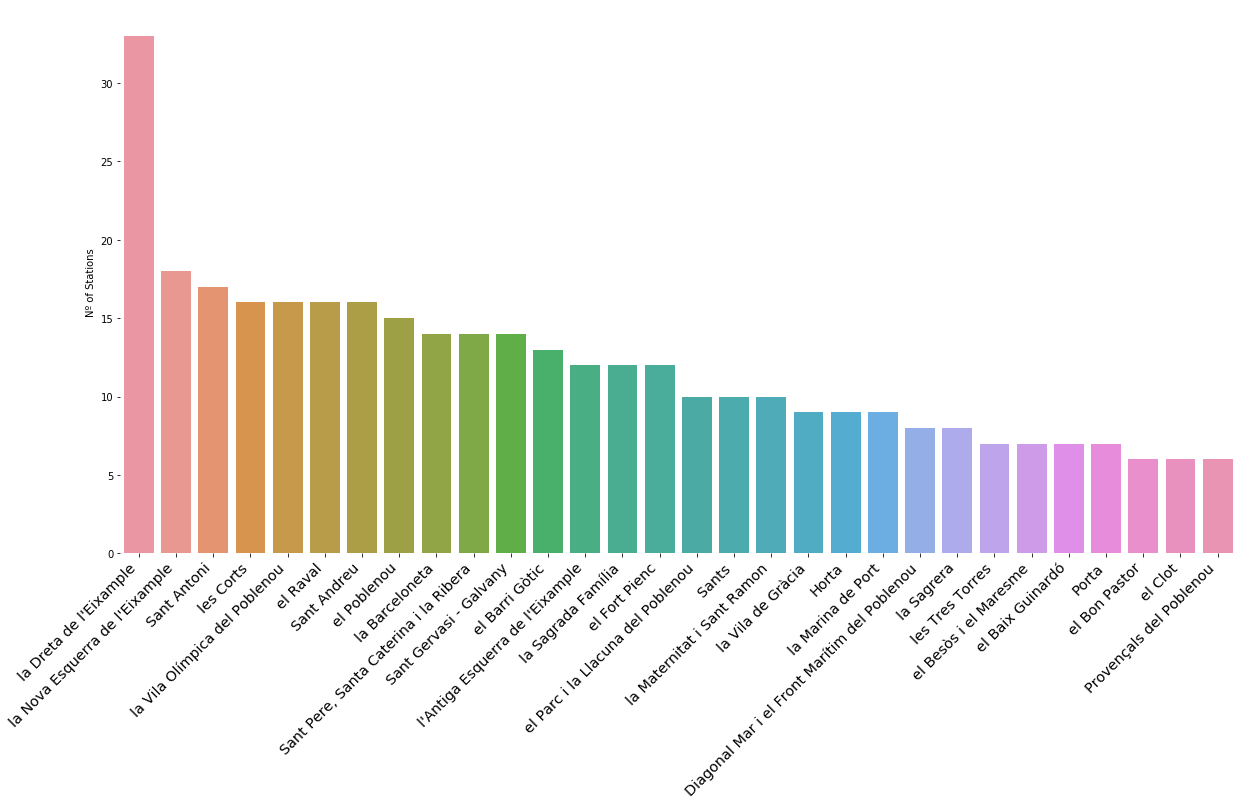

In [40]:
fig = plt.figure(figsize=(20,10))
df_2 = info.groupby('neigh').count().sort_values(['station_id'] ,ascending=False)[:30]
df_2.reset_index(inplace=True)
ax = sns.barplot(x='neigh', y='station_id', data=df_2)
ax.set(xlabel='', ylabel='Nº of Stations')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                     horizontalalignment='right', fontsize='x-large')
sns.despine(left=True, bottom=True)

## What's the most used station?

We think that `last_reported` updates every time theres a movement (either a bike is deposited or withdrawed), so we'll just have to compute the station which hast the most movements:

In [74]:
activity.groupby('station_id')['last_reported'].count().sort_values(ascending= False)[:5]

station_id
237    48474
178    48474
150    48474
151    48474
152    48474
Name: last_reported, dtype: int64

Here we can see that there's a limit on the register of the movements. We'll have to compare to a normal day usage:

In [63]:
time = activity.set_index('last_reported')

In [75]:
time.loc['2020-01-12'].groupby('station_id')['bikes'].count()[:5]

station_id
1    288
2    288
3    288
4    287
5    288
Name: bikes, dtype: int64

Here we can clearly see that the limit of registers is capped to 288/day, meaning that a station information refreshes according to a rate of once every 5 minutes. Due to this, we'll have to change our way to finding the most used station: We will find the most demanded one. We'll find it searching for the station that has the least bikes available during a day:

In [108]:
most_req_station = activity.groupby('station_id')['empty_slots'].sum().sort_values(ascending= False)[:1]

station = info.loc[int(most_req_station.index.values), ]['name']
cap = activity[activity['station_id'] == int(most_req_station.index.values)]['capacity'].max()

print(f'The most requested Bicing station is located in {station}, and it has capacity for {cap} bikes.')

The most requested Bicing station is located in PG. ZONA FRANCA, 244, and it has capacity for 54 bikes


## What's the daily usage of this station for a normal weekday, like a Wednesday? and for a Sunday?

In [316]:
zonafranca = time[time['station_id'] == int(most_req_station.index.values)]

wednesday = zonafranca.loc['2020-01-15 06:00:00':'2020-01-15 23:00:00' , ['p_bike', 'p_slot']]
sunday = zonafranca.loc['2020-01-19 06:00:00':'2020-01-19 23:00:00', ['p_bike', 'p_slot']]

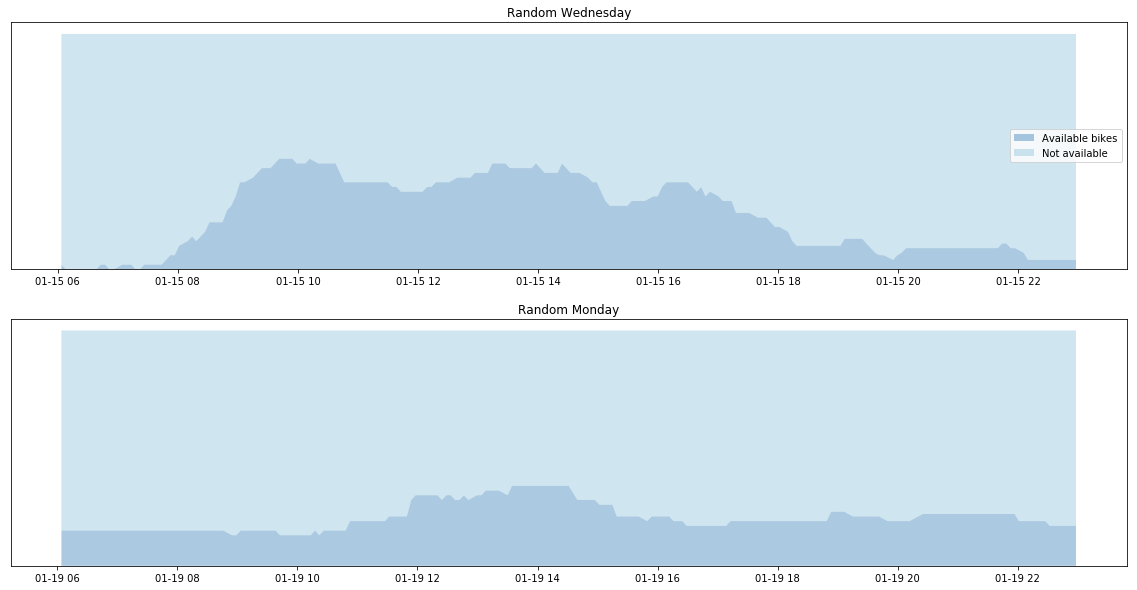

In [334]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(20,10))
pal = sns.color_palette("RdBu_r")

ax1.stackplot(wednesday.index, wednesday.p_bike, wednesday.p_slot, labels=['Available bikes','Not available'],
             colors=pal, alpha=0.4)

ax2.stackplot(sunday.index, sunday.p_bike, sunday.p_slot, labels=['Available bikes','Not available'],
             colors=pal, alpha=0.4)

ax1.yaxis.set_visible(False)
ax2.yaxis.set_visible(False)

ax1.set_title('Random Wednesday')
ax2.set_title('Random Monday')

ax1.legend(loc='center right', size=(10,1))

plt.show()


## How many rides are there in a month?

We're assuming (wrongly) that the slots unoccupied are so because the bike assigned to it is on a ride.

In [ ]:
# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")

# Plot the responses for different events and regions
sns.lineplot(x="timepoint", y="signal",
             hue="region", style="event",
             data=fmri)

In [218]:
location = geolocator.geocode("Jacquard 14, Barcelona")
location.address

'Carrer de Jacquard, Sants, Sants-Montjuïc, Barcelona, Barcelonès, Barcelona, Catalunya, 08014, España'

In [30]:
location.point

Point(41.373469, 2.1347189696437336, 0.0)

In [31]:
user_loc = location.point

In [32]:

coords_1 = (52.2296756, 21.0122287)
coords_2 = (52.406374, 16.9251681)

print(geopy.distance.distance(coords_1, coords_2).m)

279352.90160430095


In [225]:
def nearest_station(user_loc):
    
    location = geolocator.geocode(user_loc)
    loc = [list(location.point[:2])]
    dist = cdist(loc, info[['lat', 'lon']])
    index = dist[0].argmin()
    station_name = info.iloc[index]['name']
    
    return station_name.title()
    
    

In [232]:
nearest_station('Josep Tarradellas 61, Barcelona')

'Av. Josep Tarradellas, 133'

In [ ]:
nearest_station('Roselló 355, Barcelona')

In [ ]:
coor_data = info[['station_id', 'lat', 'lon']]

In [ ]:
coor_data.head()

In [ ]:
coor_data.set_index('station_id', inplace= True)

In [ ]:
user_loc = [list(location.point[:2])]
user_loc

In [ ]:
dist = cdist(user_loc, info[['lat', 'lon']])

dist

In [ ]:
dist[0].argmin()

In [ ]:
info.iloc[178]

,ID_ANNEX,ANNEXDESCR,ID_TEMA,TEMA_DESCR,ID_CONJUNT,CONJ_DESCR,ID_SUBCONJ,SCONJ_DESC,ID_ELEMENT,ELEM_DESCR,...,ESTIL_ID,ESTIL_QGIS,VALOR1QGIS,VALOR2QGIS,COL_FARCIT,FCOL_DESCR,FHEX_COLOR,COL_DESCR,HEX_COLOR7,geometry
0,01,Grup - I,0104,Unitats Administratives,010413,Barris,01041301,Barri,0104130101,Límit de barri,...,0,Sòlid,0,0,41,NULL,#E66900,NULL,#73A88F,"POLYGON ((2.16471 41.38593, 2.16936 41.38554, ..."
1,01,Grup - I,0104,Unitats Administratives,010413,Barris,01041301,Barri,0104130101,Límit de barri,...,0,Sòlid,0,0,41,NULL,#E66900,NULL,#73A88F,"POLYGON ((2.17701 41.38525, 2.17873 41.38396, ..."
2,01,Grup - I,0104,Unitats Administratives,010413,Barris,01041301,Barri,0104130101,Límit de barri,...,0,Sòlid,0,0,41,NULL,#E66900,NULL,#73A88F,"POLYGON ((2.19623 41.38745, 2.19631 41.38745, ..."
3,01,Grup - I,0104,Unitats Administratives,010413,Barris,01041301,Barri,0104130101,Límit de barri,...,0,Sòlid,0,0,41,NULL,#E66900,NULL,#73A88F,"POLYGON ((2.18345 41.39061, 2.18459 41.38976, ..."
4,01,Grup - I,0104,Unitats Administratives,010413,Barris,01041301,Barri,0104130101,Límit de barri,...,0,Sòlid,0,0,41,NULL,#E66900,NULL,#73A88F,"POLYGON ((2.18353 41.39227, 2.18238 41.39142, ..."


In [355]:
info.head()

,station_id,name,lat,lon,altitude,neigh,neigh_code
0,1,"GRAN VIA CORTS CATALANES, 760",41.397952,2.180042,21.0,el Fort Pienc,5
1,2,"C/ ROGER DE FLOR, 126",41.395530,2.177060,21.0,el Fort Pienc,5
2,3,"C/ NÀPOLS, 82",41.394055,2.181299,22.0,el Fort Pienc,5
3,4,"C/ RIBES, 13",41.393480,2.181555,21.0,el Fort Pienc,5
4,5,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",41.391075,2.180223,16.0,"Sant Pere, Santa Caterina i la Ribera",4


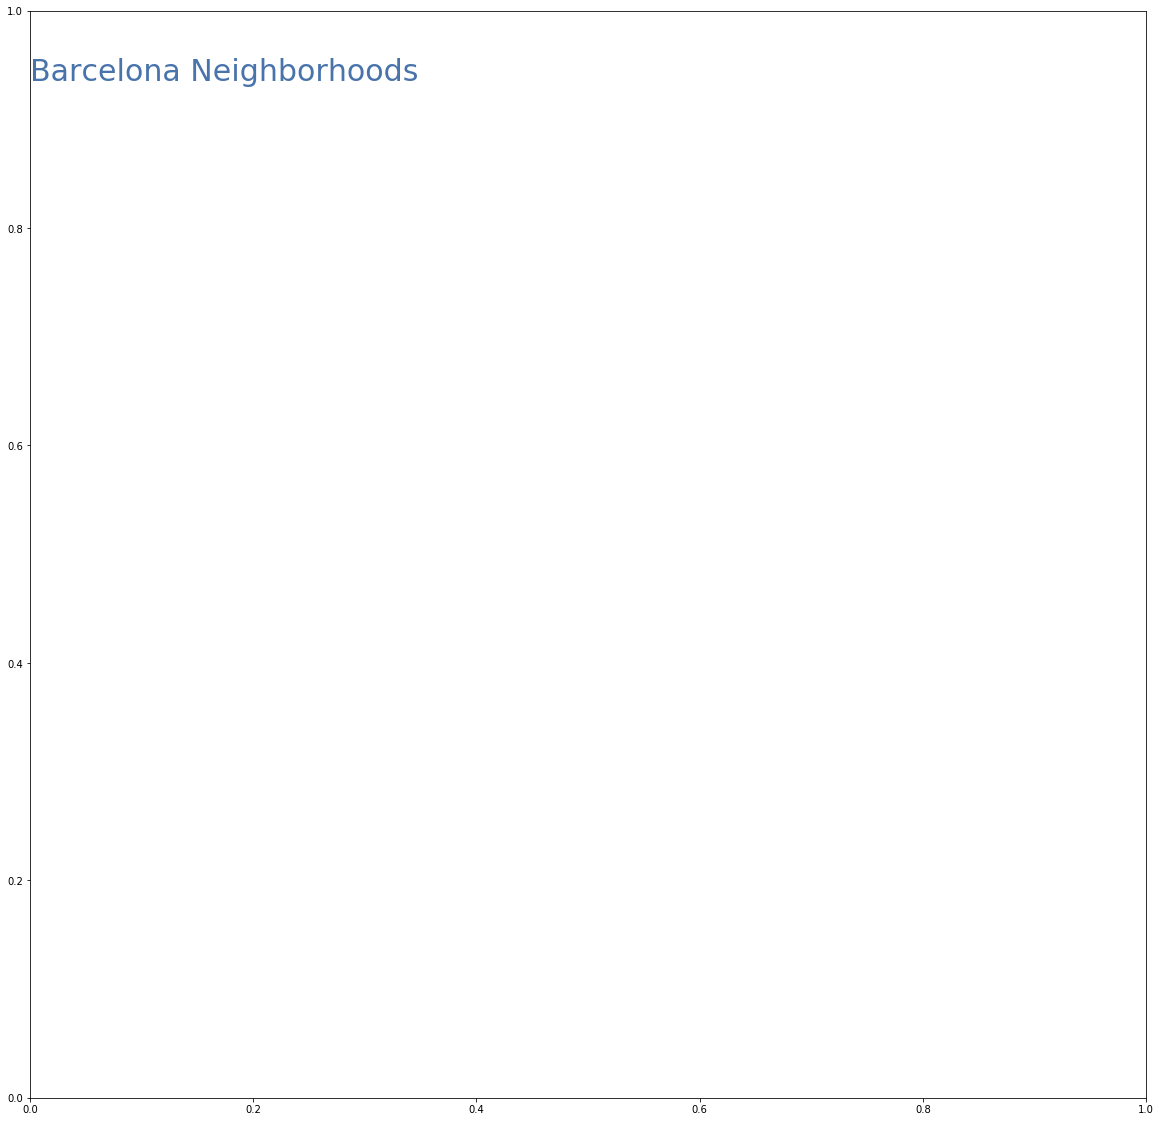

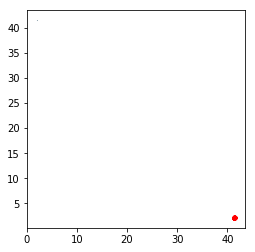

In [376]:
# Cargar la capa temática
bcn_map = "Data/barris.geojson"
map_data = gpd.read_file(bcn_map)
map_data.head()

# Control del tamaño de la figura del mapa
fig, ax= plt.subplots(1, 1, figsize=(20, 20))
 
# Control del título y los ejes
ax.set_title('Barcelona Neighborhoods', 
             pad = -70, loc='left',
             fontdict={'fontsize':30, 'color': '#4873ab'})

ax.set_xlabel('')
ax.set_ylabel('')

# Mostrar el mapa finalizado
map_data.plot()

plt.scatter(info.lat, info.lon, s=5, alpha=1, c='red', cmap="Set1")


In [ ]:
# Control del tamaño de la figura del mapa
fig, ax= plt.subplots(1, 1, figsize=(20, 20))
 
# Control del título y los ejes
ax.set_title('Barcelona Neighborhoods', 
             pad = -70, loc='left',
             fontdict={'fontsize':30, 'color': '#4873ab'})

ax.set_xlabel('')
ax.set_ylabel('')

# Mostrar el mapa finalizado
map_data.plot()

plt.scatter(info.lat, info.lon, s=5, alpha=1, c='red', cmap="Set1")


In [ ]:
ratings['timestamp'] = pd.to_datetime(ratings.timestamp, unit='s')

La idea es hacer una funcion que le des un punto A, B, y una hora, y te diga lo siguiente:
- Probabilidad de poder hacer el ride
- Tiempo aproximado que vas a tardar
- Desnivel de la estación origen a estación destino.
